In [198]:
import warnings
warnings.filterwarnings("ignore")

###Importing libraries


In [199]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

###Applying on TCS

**Downloading data of 9 years from yahoo finance**

In [200]:
data1 = yf.download('TCS.NS', start="2015-01-01", end="2025-01-01")
data1.to_csv("TCS_data.csv")

[*********************100%***********************]  1 of 1 completed


In [201]:
data=pd.read_csv("TCS_data.csv")
data.tail()

,Price,Close,High,Low,Open,Volume
2464,2024-12-24,4113.92041015625,4151.816315358072,4093.0528623167015,4093.0528623167015,1181886
2465,2024-12-26,4103.68359375,4134.049628782047,4078.140577688001,4113.920313335754,1208464
2466,2024-12-27,4099.50048828125,4115.347963377728,4082.1765493053435,4097.679420039338,858100
2467,2024-12-30,4093.545166015625,4133.409691121346,4047.479684808028,4085.8677460209447,1527169
2468,2024-12-31,4030.549560546875,4074.9912673216186,3968.7841551770334,4070.1187442915557,1555429


**Dropping empty rows and reindexing**

In [202]:
data.reset_index(inplace=True)
data = data.drop(index=[0, 1])
data = data.reset_index(drop=True)
data=data.rename(columns={'Price':'Date'})
data=data.drop(['index'],axis=1)
data.tail()

,Date,Close,High,Low,Open,Volume
2462,2024-12-24,4113.92041015625,4151.816315358072,4093.0528623167015,4093.0528623167015,1181886
2463,2024-12-26,4103.68359375,4134.049628782047,4078.140577688001,4113.920313335754,1208464
2464,2024-12-27,4099.50048828125,4115.347963377728,4082.1765493053435,4097.679420039338,858100
2465,2024-12-30,4093.545166015625,4133.409691121346,4047.479684808028,4085.8677460209447,1527169
2466,2024-12-31,4030.549560546875,4074.9912673216186,3968.7841551770334,4070.1187442915557,1555429


**Generating Test data from downloaded Data**

In [203]:
test1=data.iloc[1973:]
test1=test1.reset_index(drop=True)
data=data.iloc[:1973]
test1.tail()

,Date,Close,High,Low,Open,Volume
489,2024-12-24,4113.92041015625,4151.816315358072,4093.0528623167015,4093.0528623167015,1181886
490,2024-12-26,4103.68359375,4134.049628782047,4078.140577688001,4113.920313335754,1208464
491,2024-12-27,4099.50048828125,4115.347963377728,4082.1765493053435,4097.679420039338,858100
492,2024-12-30,4093.545166015625,4133.409691121346,4047.479684808028,4085.8677460209447,1527169
493,2024-12-31,4030.549560546875,4074.9912673216186,3968.7841551770334,4070.1187442915557,1555429


**Converting string values of Closing prices into Numeric**

In [204]:
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
test1["Close"] = pd.to_numeric(test1["Close"], errors='coerce')
data = data.dropna(subset=["Close"])  # Drop rows with missing Close prices

**Finding Maximum and Minimum values to draw plot graph properly**

In [205]:
max_value = data["Close"].max()
min_value = data["Close"].min()

print("Maximum Close Value:", max_value)
print("Minimum Close Value:", min_value)

Maximum Close Value: 3780.96630859375
Minimum Close Value: 897.4888916015625


**Plotting the training Dataset**

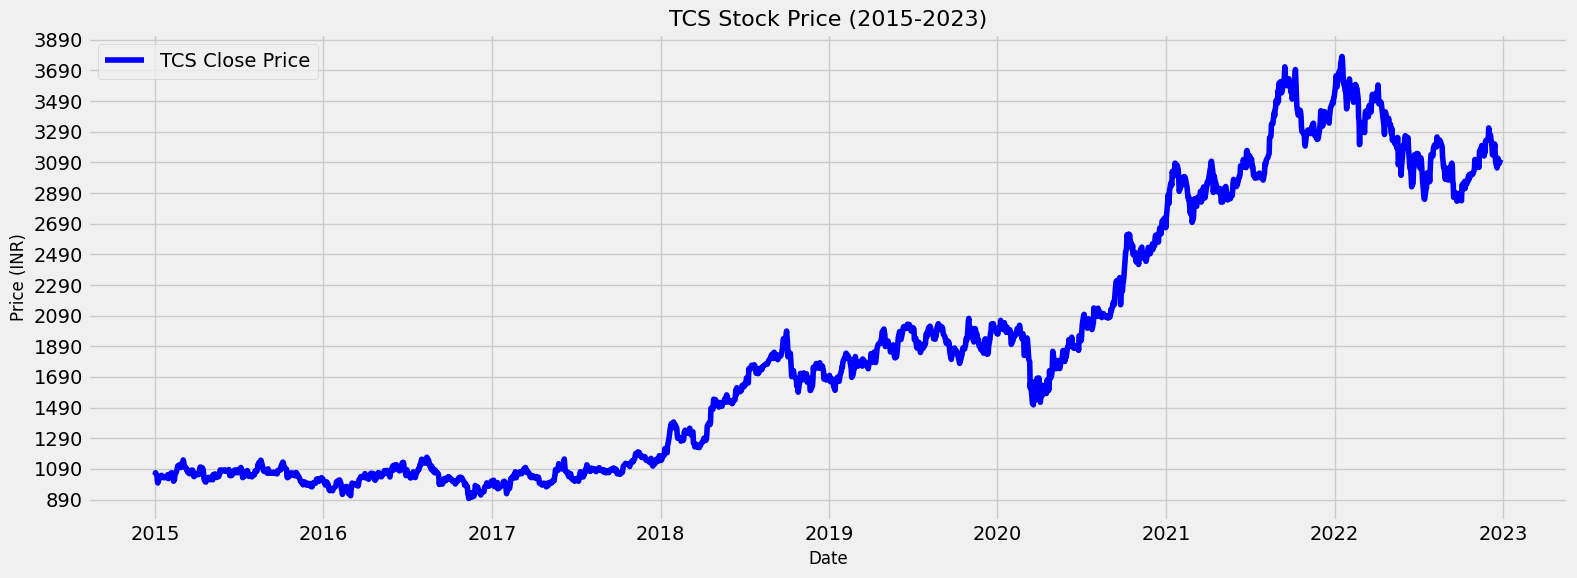

In [206]:

data["Date"] = pd.to_datetime(data["Date"])

# Step 4: Calculate y-axis tick range
y_min = int(data["Close"].min()) // 10 * 10  # Round down to nearest 10
y_max = int(data["Close"].max()) // 10 * 10 + 10  # Round up to nearest 10
y_ticks = range(y_min, y_max + 200, 200)  # Generate ticks

# Step 5: Plot the data
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the Close price against the Date
ax.plot(data["Date"], data["Close"], label="TCS Close Price", color="blue")

# Format x-axis (Date)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks yearly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.xticks(rotation=0)

# Format y-axis (Price)
ax.set_yticks(y_ticks)  # Set ticks dynamically
ax.grid(True)

# Add grid, labels, title, and legend
ax.set_title("TCS Stock Price (2015-2023)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (INR)", fontsize=12)
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**Checking Stationarity by Conducting ADF**

In [207]:
# Step 1: Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(data['Close'])

ADF Statistic: -0.49546939005355123
p-value: 0.8928975865301649
The series is not stationary.


**Performing Differencing to make data Stationary**

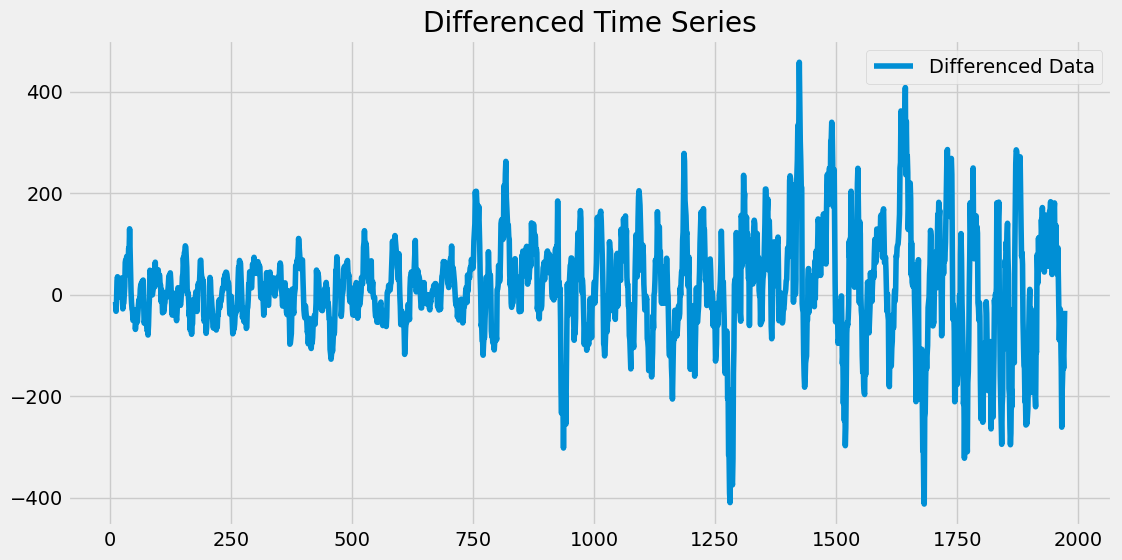

ADF Statistic: -8.416060536443126
p-value: 2.0422644315092234e-13
The series is stationary.


In [208]:

data_diff = data['Close'].diff(12).dropna()
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Differenced Data")
plt.title("Differenced Time Series")
plt.legend()
plt.show()
check_stationarity(data_diff)

**Plotting ACF and PACF plots**

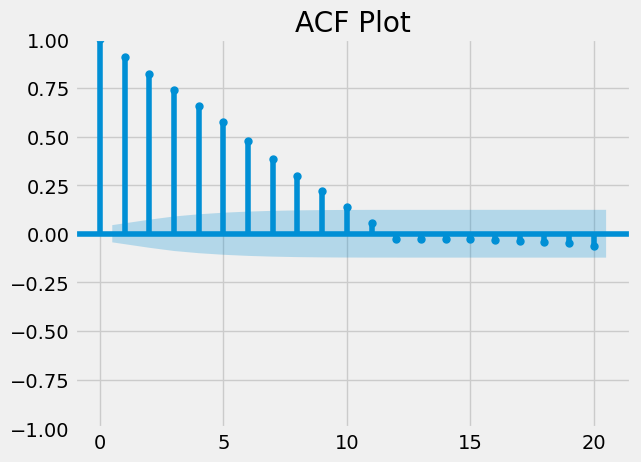

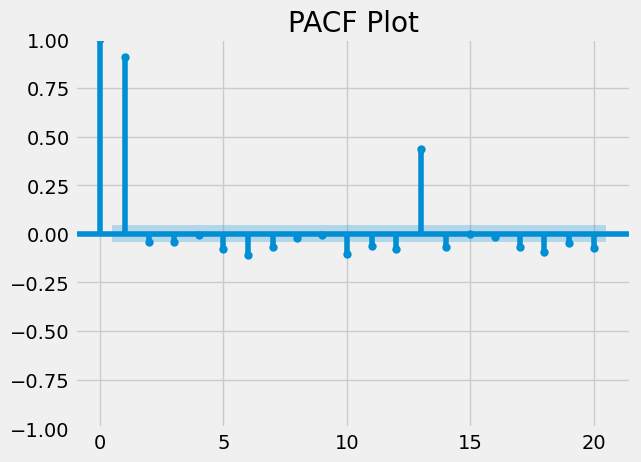

In [209]:
plot_acf(data_diff, lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(data_diff, lags=20)
plt.title("PACF Plot")
plt.show()

**Finding Predicitons and Forecasting values with ARIMA model**

In [210]:

# ARIMA Model
arima_model = ARIMA(data['Close'], order=(2, 1, 10))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=1, end=len(data), typ='levels')
arima_forecast = arima_fit.forecast(steps=30)

**# Creating Residual Data To train LSTM**:

In [211]:
residuals=data['Close']-arima_pred
residuals = residuals.dropna().reset_index(drop=True)
print(residuals)

0       14.002236
1      -16.138743
2      -38.075998
3      -12.408684
4        8.547525
          ...    
1967    22.778059
1968    -3.329172
1969   -25.959893
1970    24.623896
1971     0.206743
Length: 1972, dtype: float64


**Creating Lags Because LSTM predicts value based on previous Values**

In [212]:
def create_lagged_features(series, n_lags=60):
    data = []
    for i in range(n_lags, len(series)):
        data.append(series[i-n_lags:i].values)  # Collect past `n_lags` values

    return np.array(data)

# Define the number of past steps (lags) to use
n_lags = 60  # You can experiment with this

X_lstm = create_lagged_features(residuals, n_lags)
y_lstm = residuals[n_lags:].values  # Target values (next residual)

# Reshape X_lstm for LSTM input (samples, timesteps, features)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

**Transforming the residual into Scaler to feed into LSTM Model**

In [213]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_lstm = scaler.fit_transform(X_lstm.reshape(-1, 1)).reshape(X_lstm.shape)
y_lstm = scaler.fit_transform(y_lstm.reshape(-1, 1))

**Training the LSTM Model**

In [214]:
# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_lags, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicting residual)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train LSTM
model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.1053
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0067
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0069
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0067
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0064
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0070
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0063
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0063
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0066
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0064
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0065
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0063
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0059
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0067
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0059
Epoc

**Predicting the values from ARIMA MODEL for test Data**

In [215]:
arima_model = ARIMA(test1['Close'], order=(2, 1, 10))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_test_pred = arima_fit.predict(start=1, end=len(test1), typ='levels')
test_residuals=test1['Close']-arima_test_pred
test_residuals = test_residuals.dropna().reset_index(drop=True)
print(test_residuals)

0      10.776436
1     -11.968984
2       5.061206
3      47.054695
4       1.941922
         ...    
488    17.489042
489   -20.024400
490   -17.577106
491   -12.407075
492   -60.326788
Length: 493, dtype: float64


**Creating lagging in test data because LSTM predicts values baesd on previous values**

In [216]:
def create_lagged_features_test(series, n_lags=60):
    data = []
    for i in range(n_lags, len(series)):
        data.append(series[i-n_lags:i].values)  # Collect past `n_lags` values
    return np.array(data)

# Assuming residuals are calculated for the test set:
X_test_lstm = create_lagged_features_test(test_residuals, n_lags=60)

# Reshape to fit LSTM input shape (samples, timesteps, features)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

**Converting it into Scaler to feed into LSTM Model**

In [217]:
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, 1)).reshape(X_test_lstm.shape)

In [218]:
lstm_residual_preds = model.predict(X_test_lstm)
lstm_residual_preds = scaler.inverse_transform(lstm_residual_preds)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


**Plotting the predicted values from Hybrid Model**

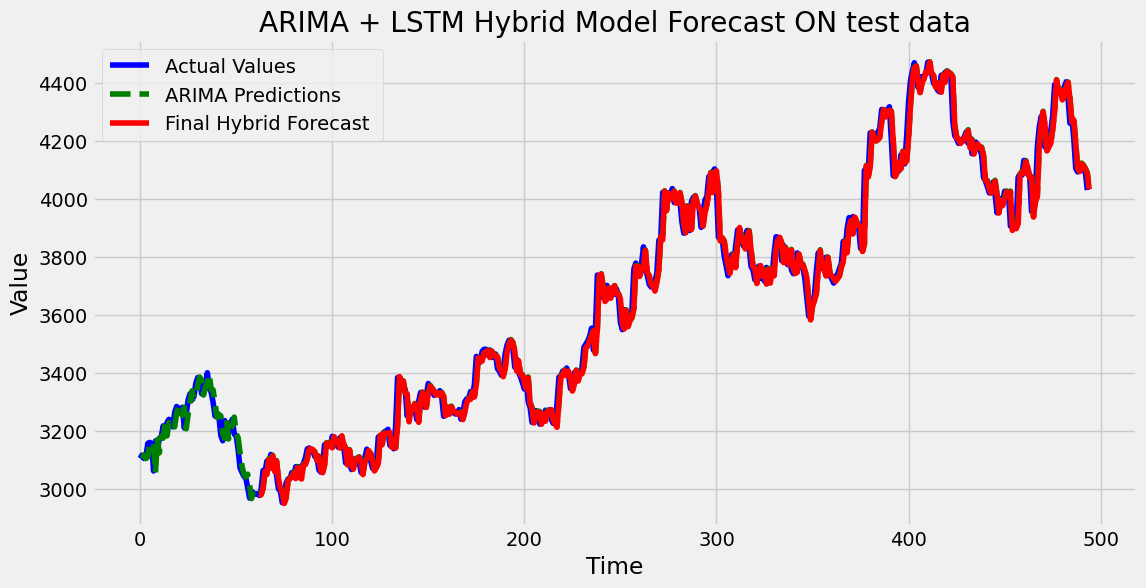

In [219]:
# Ensure ARIMA predictions and LSTM residuals have the same shape
arima_preds_trimmed = arima_test_pred[n_lags+1:]  # Remove first 60 predictions

# Compute final forecast
final_forecast = arima_preds_trimmed.values + lstm_residual_preds.flatten()

# Convert to pandas Series for visualization
final_forecast_series = pd.Series(final_forecast, index=arima_preds_trimmed.index)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test1['Close'].index, test1['Close'].values, label="Actual Values", color="blue")
plt.plot(arima_test_pred.index, arima_test_pred, label="ARIMA Predictions", color="green", linestyle="dashed")
plt.plot(final_forecast_series.index, final_forecast_series, label="Final Hybrid Forecast ", color="red")
plt.legend()
plt.title("ARIMA + LSTM Hybrid Model Forecast ON test data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


**Evaluating the model performance using RMSE,MAPE,MASE.**

In [220]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.mean(np.abs(np.diff(y_true)))  # Mean absolute difference of actual values
    mae_model = np.mean(np.abs(y_true - y_pred))  # Mean absolute error of the model
    return mae_model / naive_forecast

# Compute MASE
mase = mean_absolute_scaled_error(test1['Close'], arima_test_pred)
print(f"MASE for ARIMA: {mase:.2f}")
# Compute MAPE
mape = mean_absolute_percentage_error(test1['Close'], arima_test_pred)
print(f"MAPE for ARIMA: {mape:.2f}%")
# Compute RMSE
rmse = np.sqrt(mean_squared_error(test1['Close'], arima_test_pred))
print(f"RMSE for ARIMA: {rmse:.2f}")

# Compute MASE
mase = mean_absolute_scaled_error(test1['Close'][n_lags+1:], final_forecast_series)
print(f"MASE for hybrid model: {mase:.2f}")
# Compute MAPE
mape = mean_absolute_percentage_error(test1['Close'][n_lags+1:], final_forecast_series)
print(f"MAPE for hybrid model: {mape:.2f}%")
# Compute RMSE
rmse = np.sqrt(mean_squared_error(test1['Close'][n_lags+1:], final_forecast_series))
print(f"RMSE for hybrid model: {rmse:.2f}")

MASE for ARIMA: 1.00
MAPE for ARIMA: 0.90%
RMSE for ARIMA: 7.46
MASE for hybrid model: 1.00
MAPE for hybrid model: 0.89%
RMSE for hybrid model: 7.86


###Applying on NIFTY-50

**Downloading data of 9 years from yahoo finance**

In [221]:
data1 = yf.download('^NSEI', start="2015-01-01", end="2025-01-01")
data1.to_csv("NIFTY_data.csv")

[*********************100%***********************]  1 of 1 completed


In [222]:
data=pd.read_csv("NIFTY_data.csv")
data.tail()

,Price,Close,High,Low,Open,Volume
2456,2024-12-24,23727.650390625,23867.650390625,23685.150390625,23769.099609375,177700
2457,2024-12-26,23750.19921875,23854.5,23653.599609375,23775.80078125,177700
2458,2024-12-27,23813.400390625,23938.849609375,23800.599609375,23801.400390625,176800
2459,2024-12-30,23644.900390625,23915.349609375,23599.30078125,23796.900390625,364900
2460,2024-12-31,23644.80078125,23689.849609375,23460.44921875,23560.599609375,193600


**Dropping empty rows and reindexing**

In [223]:
data.reset_index(inplace=True)
data = data.drop(index=[0, 1])
data = data.reset_index(drop=True)
data=data.rename(columns={'Price':'Date'})
data=data.drop(['index'],axis=1)
data.tail()

,Date,Close,High,Low,Open,Volume
2454,2024-12-24,23727.650390625,23867.650390625,23685.150390625,23769.099609375,177700
2455,2024-12-26,23750.19921875,23854.5,23653.599609375,23775.80078125,177700
2456,2024-12-27,23813.400390625,23938.849609375,23800.599609375,23801.400390625,176800
2457,2024-12-30,23644.900390625,23915.349609375,23599.30078125,23796.900390625,364900
2458,2024-12-31,23644.80078125,23689.849609375,23460.44921875,23560.599609375,193600


**Generating Test data from downloaded Data**

In [224]:
test1=data.iloc[1967:]
test1=test1.reset_index(drop=True)
data=data.iloc[:1967]
test1.tail()

,Date,Close,High,Low,Open,Volume
487,2024-12-24,23727.650390625,23867.650390625,23685.150390625,23769.099609375,177700
488,2024-12-26,23750.19921875,23854.5,23653.599609375,23775.80078125,177700
489,2024-12-27,23813.400390625,23938.849609375,23800.599609375,23801.400390625,176800
490,2024-12-30,23644.900390625,23915.349609375,23599.30078125,23796.900390625,364900
491,2024-12-31,23644.80078125,23689.849609375,23460.44921875,23560.599609375,193600


**Converting string values of Closing prices into Numeric**

In [225]:
data["Close"] = pd.to_numeric(data["Close"], errors='coerce')
test1["Close"] = pd.to_numeric(test1["Close"], errors='coerce')
data = data.dropna(subset=["Close"])  # Drop rows with missing Close prices

**Finding Maximum and Minimum values to draw plot graph properly**

In [226]:
max_value = data["Close"].max()
min_value = data["Close"].min()

print("Maximum Close Value:", max_value)
print("Minimum Close Value:", min_value)

Maximum Close Value: 18812.5
Minimum Close Value: 6970.60009765625


**Plotting the training Dataset**

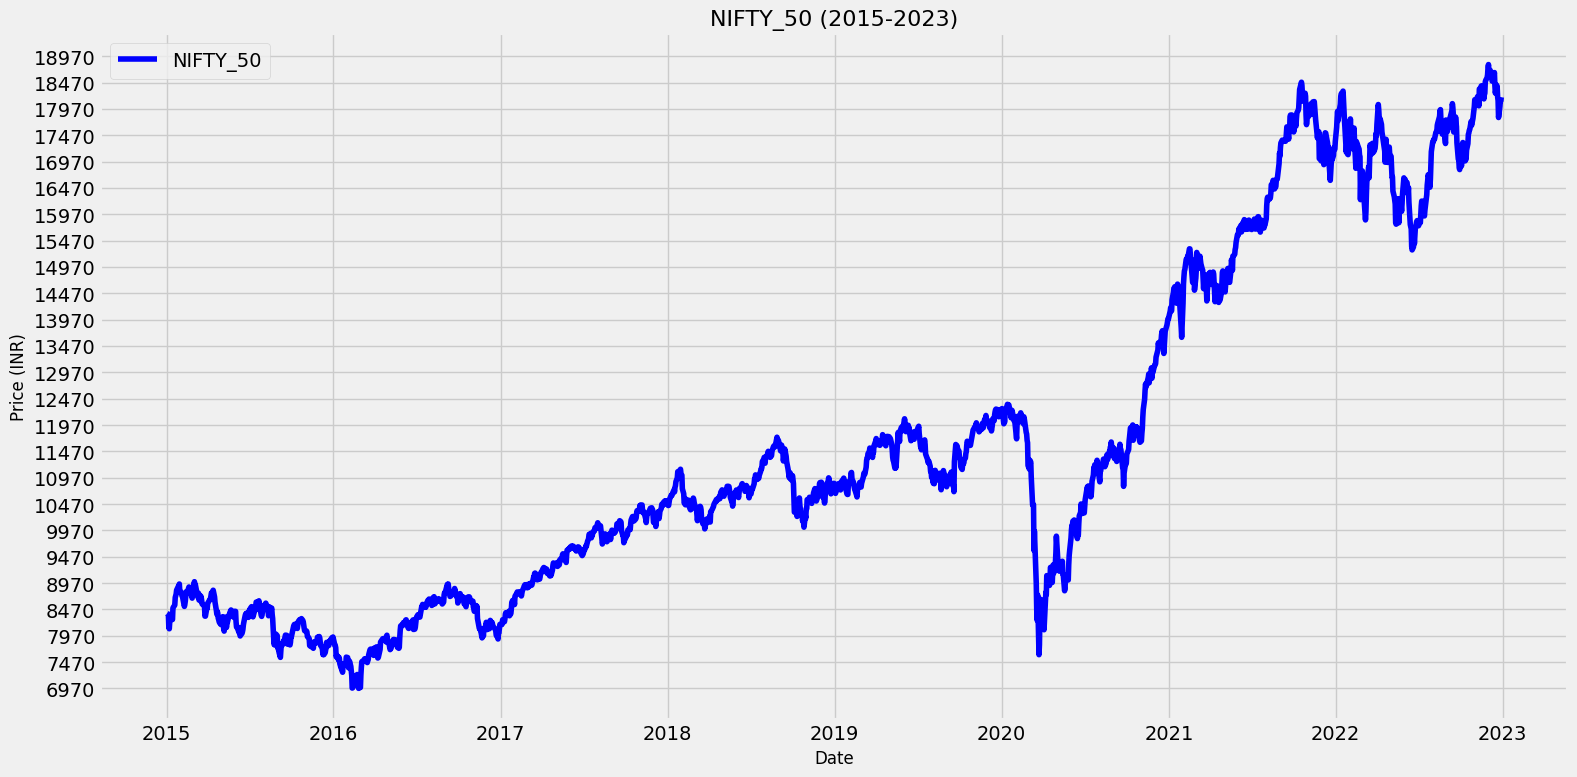

In [227]:

data["Date"] = pd.to_datetime(data["Date"])

# Step 4: Calculate y-axis tick range
y_min = int(data["Close"].min()) // 10 * 10  # Round down to nearest 10
y_max = int(data["Close"].max()) // 10 * 10 + 10  # Round up to nearest 10
y_ticks = range(y_min, y_max + 500, 500)  # Generate ticks

# Step 5: Plot the data
fig, ax = plt.subplots(figsize=(16, 8))

# Plot the Close price against the Date
ax.plot(data["Date"], data["Close"], label="NIFTY_50", color="blue")

# Format x-axis (Date)
ax.xaxis.set_major_locator(mdates.YearLocator())  # Show major ticks yearly
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.xticks(rotation=0)

# Format y-axis (Price)
ax.set_yticks(y_ticks)  # Set ticks dynamically
ax.grid(True)

# Add grid, labels, title, and legend
ax.set_title("NIFTY_50 (2015-2023)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (INR)", fontsize=12)
ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**Checking Stationarity by Conducting ADF**

In [228]:
# Step 1: Check Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(data['Close'])

ADF Statistic: -0.08609240998567537
p-value: 0.9508062848820259
The series is not stationary.


**Performing Differencing to make data Stationary**

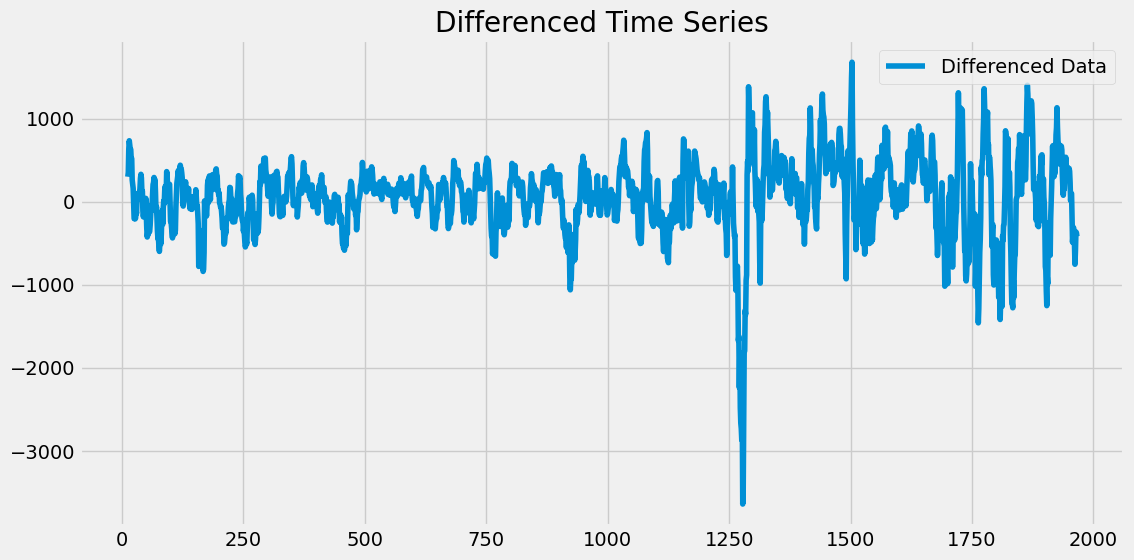

ADF Statistic: -6.892661303834099
p-value: 1.343254307194564e-09
The series is stationary.


In [229]:

data_diff = data['Close'].diff(12).dropna()
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Differenced Data")
plt.title("Differenced Time Series")
plt.legend()
plt.show()
check_stationarity(data_diff)

**Plotting ACF and PACF plots**

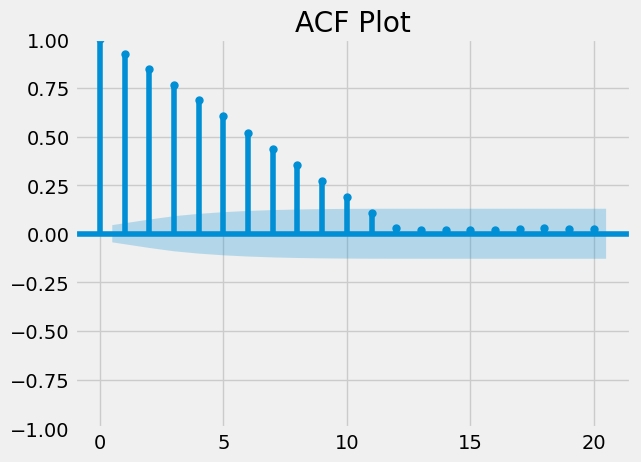

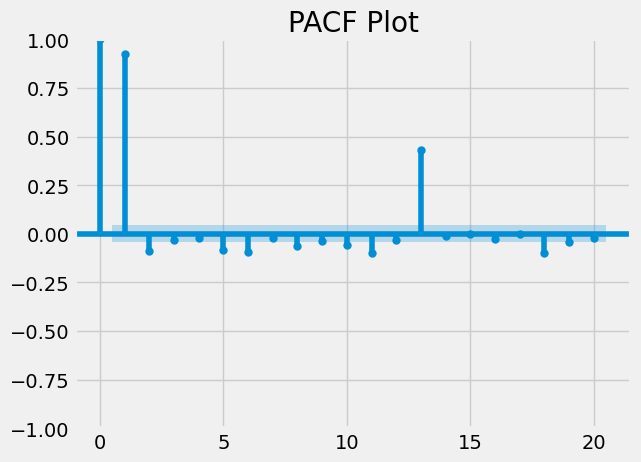

In [230]:
plot_acf(data_diff, lags=20)
plt.title("ACF Plot")
plt.show()

plot_pacf(data_diff, lags=20)
plt.title("PACF Plot")
plt.show()

**Finding Predicitons and Forecasting values with ARIMA model**

In [231]:

# ARIMA Model
arima_model = ARIMA(data['Close'], order=(3, 1, 11))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_pred = arima_fit.predict(start=1, end=len(data), typ='levels')
arima_forecast = arima_fit.forecast(steps=30)

**Calculating Residual Values to train LSTM model**

In [232]:
residuals=data['Close']-arima_pred
residuals = residuals.dropna().reset_index(drop=True)
print(residuals)

0       -18.283639
1      -250.658571
2       -21.109589
3       128.771248
4        33.586570
           ...    
1961   -324.159268
1962    188.668555
1963    143.058045
1964    -11.220195
1965     79.639464
Length: 1966, dtype: float64


**Creating lagging in data becuase LSTM predict values baesd in previous values**

In [233]:
def create_lagged_features(series, n_lags=60):
    data = []
    for i in range(n_lags, len(series)):
        data.append(series[i-n_lags:i].values)  # Collect past `n_lags` values

    return np.array(data)

# Define the number of past steps (lags) to use
n_lags = 60  # You can experiment with this

X_lstm = create_lagged_features(residuals, n_lags)
y_lstm = residuals[n_lags:].values  # Target values (next residual)

# Reshape X_lstm for LSTM input (samples, timesteps, features)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

**Scaling the data for feeding it into LSTM**

In [234]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_lstm = scaler.fit_transform(X_lstm.reshape(-1, 1)).reshape(X_lstm.shape)
y_lstm = scaler.fit_transform(y_lstm.reshape(-1, 1))

**Training the LSTM model**

In [235]:
# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_lags, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicting residual)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train LSTM
model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.1760
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0053
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0058
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0049
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0055
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0064
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0055
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0066
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0061
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0054
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0056
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0062
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0061
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0061
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0060
Epoc

**Finding Residuals for test dataset**

In [236]:
arima_model = ARIMA(test1['Close'], order=(3, 1, 11))  # Adjust 'd' for differencing
arima_fit = arima_model.fit()
arima_test_pred = arima_fit.predict(start=1, end=len(test1), typ='levels')
test_residuals=test1['Close']-arima_test_pred
test_residuals = test_residuals.dropna().reset_index(drop=True)
print(test_residuals)

0      127.880228
1        5.561534
2     -193.967771
3      -82.349905
4      -59.236737
          ...    
486    -68.549057
487    -21.909931
488     11.509945
489   -257.840851
490    -22.672649
Length: 491, dtype: float64


**Creating lagging in Test Data**

In [237]:
def create_lagged_features_test(series, n_lags=60):
    data = []
    for i in range(n_lags, len(series)):
        data.append(series[i-n_lags:i].values)  # Collect past `n_lags` values
    return np.array(data)

# Assuming residuals are calculated for the test set:
X_test_lstm = create_lagged_features_test(test_residuals, n_lags=60)

# Reshape to fit LSTM input shape (samples, timesteps, features)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

**Scalining the data for feeding into LSTM**

In [238]:
X_test_lstm = scaler.transform(X_test_lstm.reshape(-1, 1)).reshape(X_test_lstm.shape)

**Getting the test Values from trained LSTM model**

In [239]:
lstm_residual_preds = model.predict(X_test_lstm)
lstm_residual_preds = scaler.inverse_transform(lstm_residual_preds)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


**trimming hte data because of Lagging**

In [240]:
arima_preds_trimmed = arima_test_pred[61:]

**Plotting the predicted Values from ARIMA + LSTM Hybrid Model**

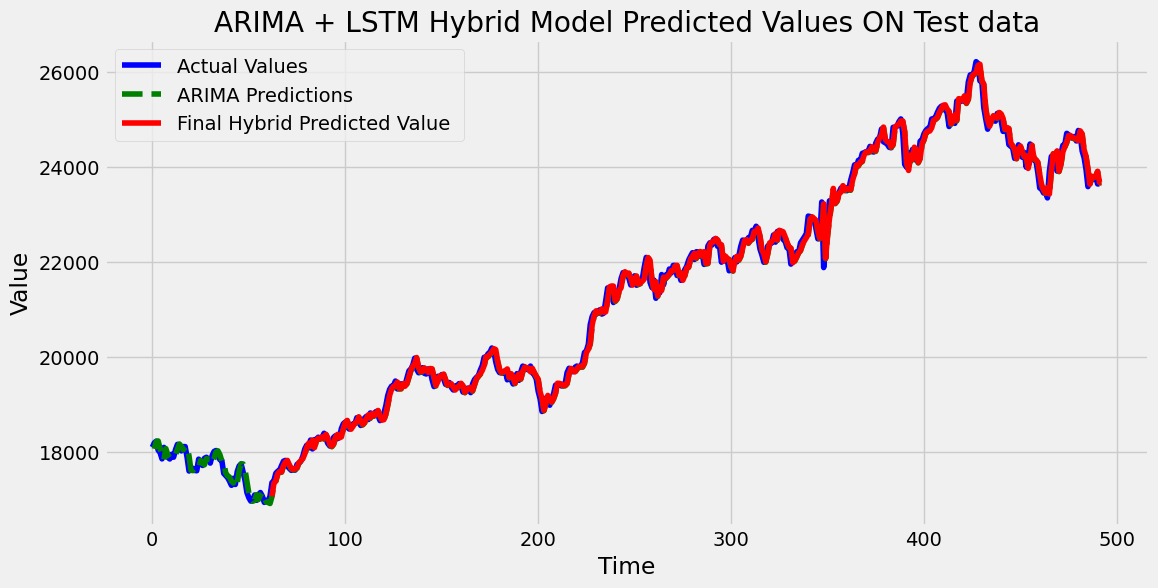

In [241]:
# Ensure ARIMA predictions and LSTM residuals have the same shape
arima_preds_trimmed = arima_test_pred[n_lags+1:]  # Remove first 60 predictions

# Compute final forecast
final_forecast = arima_preds_trimmed.values + lstm_residual_preds.flatten()

# Convert to pandas Series for visualization
final_forecast_series = pd.Series(final_forecast, index=arima_preds_trimmed.index)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test1['Close'].index, test1['Close'].values, label="Actual Values", color="blue")
plt.plot(arima_test_pred.index, arima_test_pred, label="ARIMA Predictions", color="green", linestyle="dashed")
plt.plot(final_forecast_series.index, final_forecast_series, label="Final Hybrid Predicted Value ", color="red")
plt.legend()
plt.title("ARIMA + LSTM Hybrid Model Predicted Values ON Test data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


**Calculating Model Performance using MASE, MAPE, RMSE**

In [242]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.mean(np.abs(np.diff(y_true)))  # Mean absolute difference of actual values
    mae_model = np.mean(np.abs(y_true - y_pred))  # Mean absolute error of the model
    return mae_model / naive_forecast

# Compute MASE
mase = mean_absolute_scaled_error(test1['Close'], arima_test_pred)
print(f"MASE for ARIMA: {mase:.2f}")
# Compute MAPE
mape = mean_absolute_percentage_error(test1['Close'], arima_test_pred)
print(f"MAPE for ARIMA: {mape:.2f}%")
# Compute RMSE
rmse = np.sqrt(mean_squared_error(test1['Close'], arima_test_pred))
print(f"RMSE for ARIMA: {rmse:.2f}")

# Compute MASE
mase = mean_absolute_scaled_error(test1['Close'][n_lags+1:], final_forecast_series)
print(f"MASE for hybrid model: {mase:.2f}")
# Compute MAPE
mape = mean_absolute_percentage_error(test1['Close'][n_lags+1:], final_forecast_series)
print(f"MAPE for hybrid model: {mape:.2f}%")
# Compute RMSE
rmse = np.sqrt(mean_squared_error(test1['Close'][n_lags+1:], final_forecast_series))
print(f"RMSE for hybrid model: {rmse:.2f}")

MASE for ARIMA: 1.00
MAPE for ARIMA: 0.55%
RMSE for ARIMA: 34.37
MASE for hybrid model: 1.00
MAPE for hybrid model: 0.54%
RMSE for hybrid model: 37.00
